# Proteomics course data analysis 
-------------
version 2019-11-20 (zaro)


In [1]:
#install.packages("openxlsx", dependencies = TRUE)
#install.packages("ggpubr")
#install.packages("factoextra")
#install.packages("pheatmap")
#install.packages('BiocManager')
#BiocManager::install('EnhancedVolcano')
#BiocManager::install('ReactomePA')
#BiocManager::install("clusterProfiler")
#BiocManager::install("org.Hs.eg.db")

In [2]:
library(ggpubr)
library(tidyverse)
library(factoextra)
library(pheatmap)
library(EnhancedVolcano)
library(ReactomePA)
library(clusterProfiler)
library(org.Hs.eg.db)
library(openxlsx)

Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: magrittr
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.1       ✔ purrr   0.3.2  
✔ tidyr   0.8.3       ✔ dplyr   0.8.0.1
✔ readr   1.3.1       ✔ stringr 1.4.0  
✔ tibble  2.1.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()
Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ
Loading required package: ggrepel

Registered S3 method overwritten by 'enrichplot':
  method          

# (1) data simulation

In this case we have only one real data set (treatment and control) and simulate the other samples to be able to test some of the basic concepts of omics data analysis.

In [3]:
data.raw <- read.xlsx(xlsxFile="Praktikum_Proteomics_Sysbio.xlsx", sheet = 1, startRow = 1, colNames = TRUE,
  rowNames = FALSE)
head(data.raw)
colnames(data.raw) <- c("protein","ctrl_1","treat_1")
head(data.raw)

Protein.IDs,Control.[Intensity],Treatment.[Intensity]
<chr>,<dbl>,<dbl>
C9J600,75877.0,61317.0
A0A024RBD0,0.0,35093.0
A0A024RDB0,797730.0,732160.0
A0JNW5,9395.7,8861.2
A0MZ66,4336.3,4337.7
A1L0T0,0.0,205780.0


protein,ctrl_1,treat_1
<chr>,<dbl>,<dbl>
C9J600,75877.0,61317.0
A0A024RBD0,0.0,35093.0
A0A024RDB0,797730.0,732160.0
A0JNW5,9395.7,8861.2
A0MZ66,4336.3,4337.7
A1L0T0,0.0,205780.0


In [4]:
set.seed(123)
generate_intensity <- function(x) {rnorm(n=1,mean=x,sd=0.1*x)}
data.raw$ctrl_2 <- sapply(data.raw$ctrl_1,generate_intensity)
data.raw$ctrl_3 <- sapply(data.raw$ctrl_1*2.0,generate_intensity)
data.raw$ctrl_4 <- sapply(data.raw$ctrl_1*3.0,generate_intensity)
data.raw$treat_2 <- sapply(data.raw$treat_1,generate_intensity)
data.raw$treat_3 <- sapply(data.raw$treat_1*0.1,generate_intensity)
data.raw$treat_4 <- data.raw$ctrl_1[sample(1:nrow(data.raw),nrow(data.raw))]
data.raw <- data.raw[,c(1,2,4,5,6,3,7,8,9)]
head(data.raw)


protein,ctrl_1,ctrl_2,ctrl_3,ctrl_4,treat_1,treat_2,treat_3,treat_4
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C9J600,75877.0,71624.279,151096.187,252080.88,61317.0,60255.379,5910.3421,15757
A0A024RBD0,0.0,0.000,0.000,0.00,35093.0,33151.778,3244.9288,90383
A0A024RDB0,797730.0,779368.051,1514065.942,2415643.42,732160.0,661298.844,77586.8274,1051000
A0JNW5,9395.7,10860.216,17244.081,26008.05,8861.2,9233.987,812.3293,44666
A0MZ66,4336.3,4366.875,9411.381,13778.05,4337.7,4277.487,366.7515,28655
A1L0T0,0.0,0.000,0.000,0.00,205780.0,250424.502,22271.5493,63501


In [5]:
data.raw %>% dplyr::select(protein,ctrl_1,treat_1) %>% write.xlsx(file = "raw_data_set_1.xlsx", row.names = FALSE)
data.raw %>% dplyr::select(protein,ctrl_2,treat_2) %>% write.xlsx(file = "raw_data_set_2.xlsx", row.names = FALSE)
data.raw %>% dplyr::select(protein,ctrl_3,treat_3) %>% write.xlsx(file = "raw_data_set_3.xlsx", row.names = FALSE)
data.raw %>% dplyr::select(protein,ctrl_4,treat_4) %>% write.xlsx(file = "raw_data_set_4.xlsx", row.names = FALSE)

Note: zip::zip() is deprecated, please use zip::zipr() instead


# (2) data preparation

We are going to load either real data sets or the provided simulated data sets and merge them into on data matrix.

In [6]:
data.set1 <- read.xlsx(xlsxFile="raw_data_set_1.xlsx")
colnames(data.set1) <- c("protein","ctrl_1","treat_1")

data.set2 <- read.xlsx(xlsxFile="raw_data_set_2.xlsx")
colnames(data.set2) <- c("protein","ctrl_2","treat_2")

data.set3 <- read.xlsx(xlsxFile="raw_data_set_3.xlsx")
colnames(data.set3) <- c("protein","ctrl_3","treat_3")

data.set4 <- read.xlsx(xlsxFile="raw_data_set_4.xlsx")
colnames(data.set4) <- c("protein","ctrl_4","treat_4")

data.raw <- full_join(data.set1,data.set2)
data.raw <- full_join(data.raw,data.set3)
data.raw <- full_join(data.raw,data.set4)

data.raw <- data.raw[,c(1,2,4,6,8,3,5,7,9)]

head(data.raw)

Joining, by = "protein"
Joining, by = "protein"
Joining, by = "protein"


protein,ctrl_1,ctrl_2,ctrl_3,ctrl_4,treat_1,treat_2,treat_3,treat_4
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C9J600,75877.0,71624.279,151096.187,252080.88,61317.0,60255.379,5910.3421,15757
A0A024RBD0,0.0,0.000,0.000,0.00,35093.0,33151.778,3244.9288,90383
A0A024RDB0,797730.0,779368.051,1514065.942,2415643.42,732160.0,661298.844,77586.8274,1051000
A0JNW5,9395.7,10860.216,17244.081,26008.05,8861.2,9233.987,812.3293,44666
A0MZ66,4336.3,4366.875,9411.381,13778.05,4337.7,4277.487,366.7515,28655
A1L0T0,0.0,0.000,0.000,0.00,205780.0,250424.502,22271.5493,63501


We need to deal with "NA" (not a number) table entries caused by proteins which are detected in one sample but not in another one. We are replacing them by half of the minimum intensity value. This process is refered to as **"data imputation"**.

In [7]:
dat.matrix <- data.raw[,2:ncol(data.raw)]

# replace "NA" with 0.0
dat.matrix[is.na(dat.matrix)] <- 0.0

# identify proteins with more than 50% of samples showing 0.0 intensity
id.LOD <- rowSums(dat.matrix==0) > (ncol(data.raw)-1)/2

# find minimum value of whole data matrix (we will use this later...)
min.intensity <- min(dat.matrix[dat.matrix!=0])

min.intensity

data.raw[,2:ncol(data.raw)] <- dat.matrix

# discard proteins marked as below limit of detection (LOD) in majority of samples
data.raw <- data.raw[!id.LOD,]

[1] 42.32487

It is always advisable to run some basic visual inspections of the provided data, therefore we plot the data in a boxplot and a density plot.

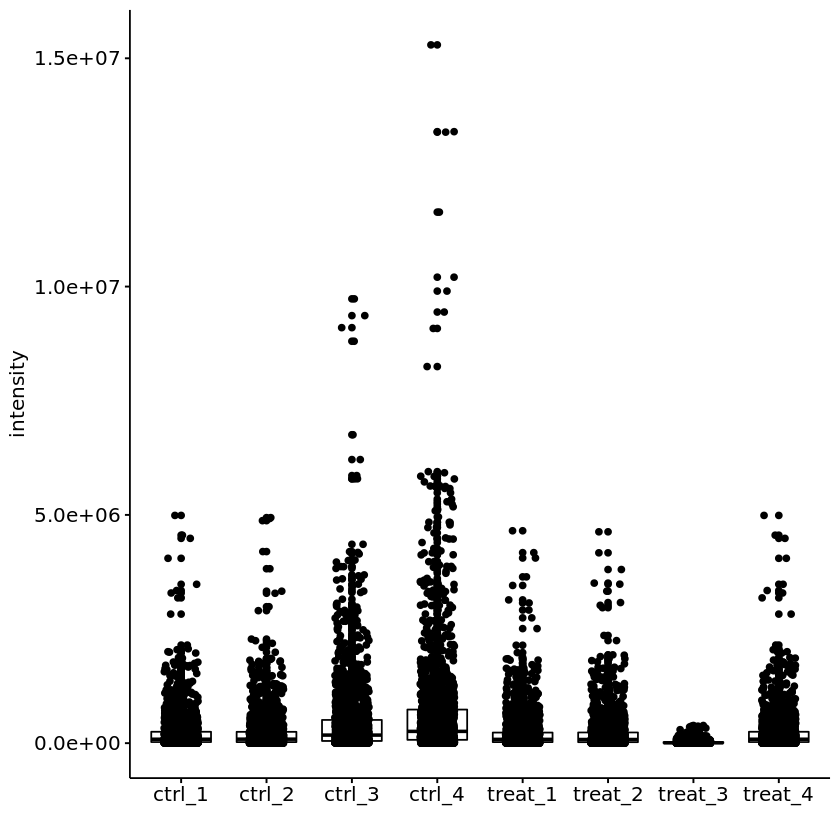

In [8]:
ggboxplot(gather(data.raw,colnames(data.raw)[2:ncol(data.raw)],key="sample",value="intensity"), 
          x = "sample", y="intensity", xlab="",
         palette = get_palette(palette = "npg", 6),
         add = "jitter")

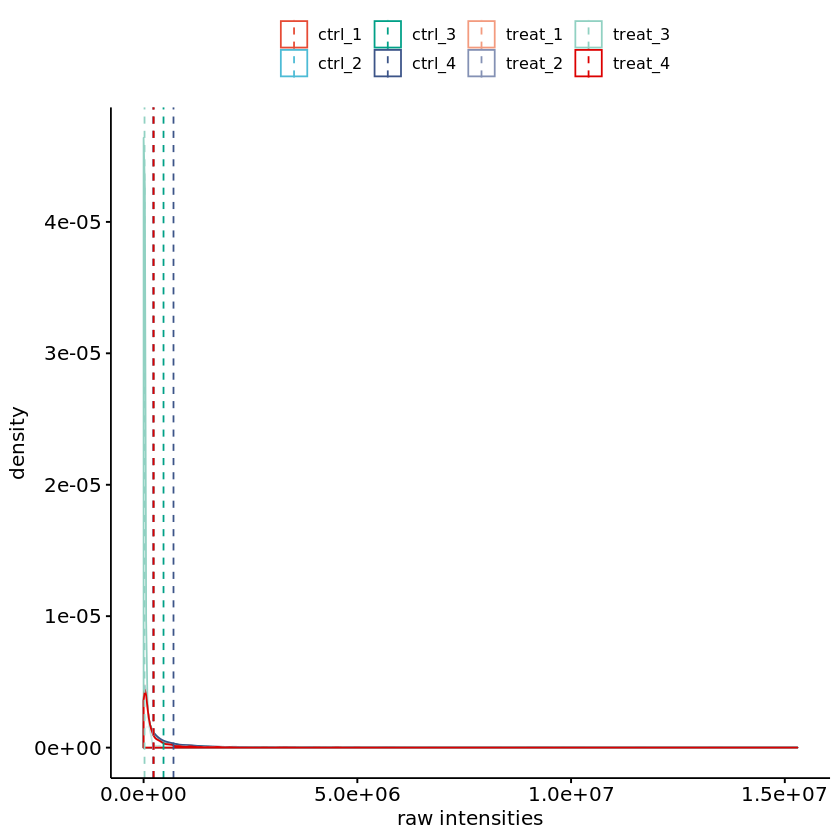

In [9]:
ggdensity(data.raw, x = colnames(data.raw)[2:ncol(data.raw)],
   add = "mean", merge=TRUE, xlab="raw intensities",
   palette = get_palette(palette = "npg", ncol(data.raw)-1))

# (3) data pre-processing

As samples "treat_3" and "ctrl_3" appear shifted in the boxplot we can apply a **normalization** step by substracting the median of intensities from each sample and therefore reduce system biases.
  $$intensity_{normalized}=intensity_{i,n} \cdot \frac{\frac{1}{N}\sum{median(intensities_{n})}}{median(intensities_{n})}$$  
There is wide variety of normalization strategies, some of them summarized in [Tommi Välikangas *et.al.*;2018](https://academic.oup.com/bib/article/19/1/1/2562889).

In [10]:
data.norm <- data.raw
mean.medians <- mean(apply(data.norm[,2:ncol(data.norm)],2,median))
norm.factors <- mean.medians/apply(data.norm[,2:ncol(data.norm)],2,median)
round(norm.factors,1)
data.norm[,2:ncol(data.norm)] <- sweep(data.norm[,2:ncol(data.norm)], 2, norm.factors, "*")

ctrl_1  ctrl_2  ctrl_3  ctrl_4 treat_1 treat_2 treat_3 treat_4 
    1.3     1.2     0.6     0.4     1.3     1.3    13.1     1.3

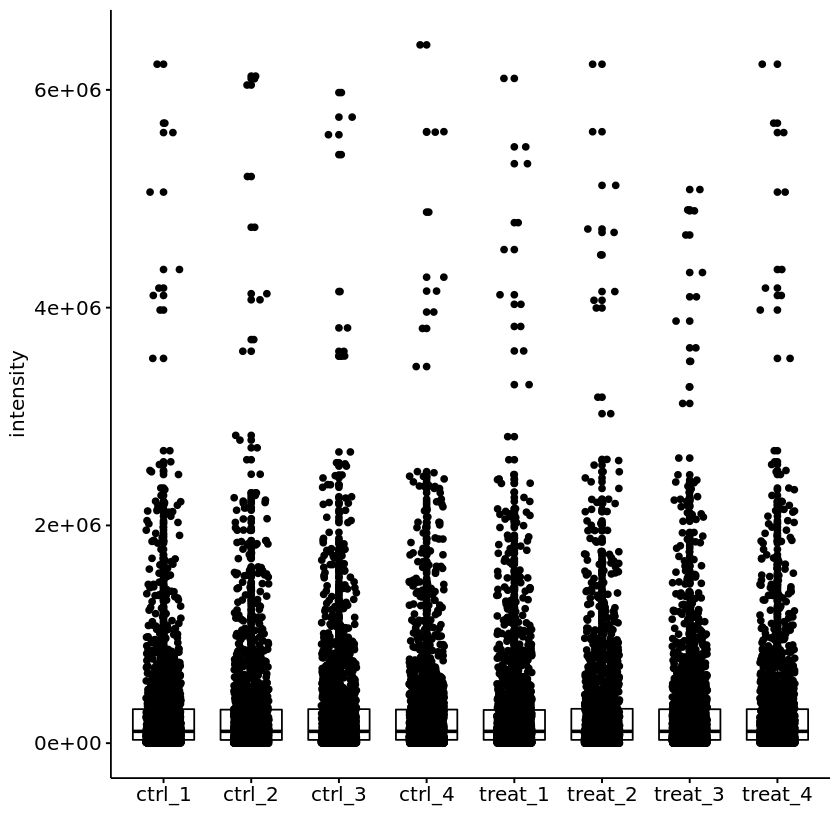

In [11]:
ggboxplot(gather(data.norm,colnames(data.norm)[2:ncol(data.norm)],key="sample",value="intensity"), 
          x = "sample", y="intensity", xlab="", 
         palette = get_palette(palette = "npg", 6),
         add = "jitter")

A **log2 transformation** of the data should
reshape the distribution to a more "normal" like.

In [12]:
data.trans <- data.norm
data.trans[,2:ncol(data.trans)] <- log2(data.norm[,2:ncol(data.norm)])

Warning message:
“Removed 256 rows containing non-finite values (stat_density).”

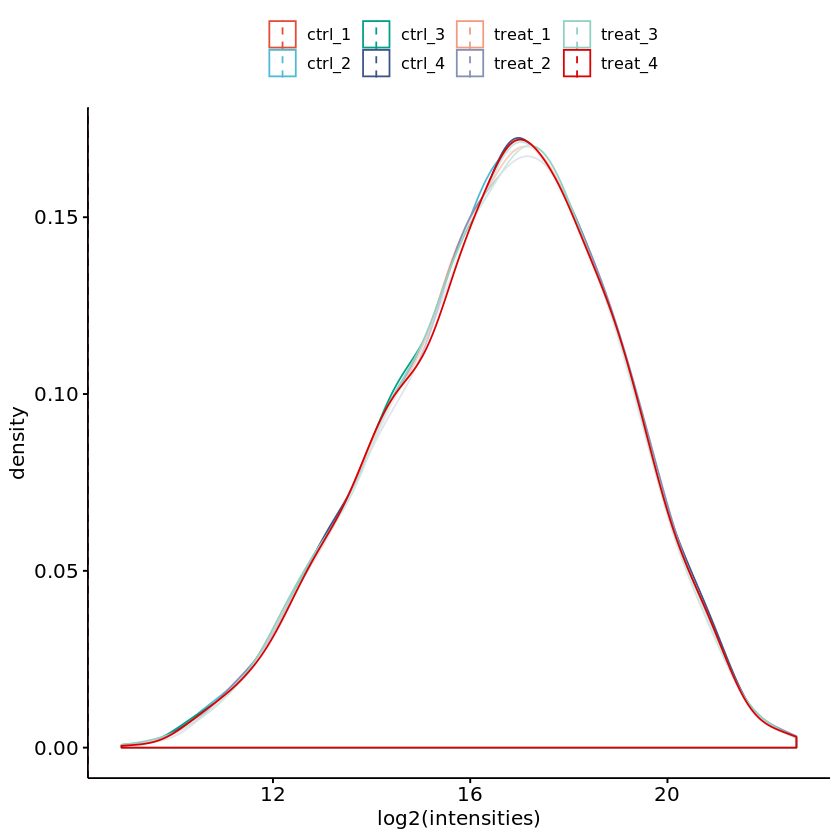

In [13]:
ggdensity(data.trans, x = colnames(data.trans)[2:ncol(data.trans)],
   add = "mean", merge=TRUE, xlab="log2(intensities)", 
   palette = get_palette(palette = "npg", ncol(data.trans)-1))

As we get a warning of removed values, we have to rethink the way we want to deal with "0" intensity values, as they cause troubles during log2 transformation.  We will **impute missing values** ("0" intensities) by replacing them with half of the minimum values measured.

In [14]:
data.trans <- data.norm
dat.matrix <- data.norm[,2:ncol(data.norm)]

dat.matrix[dat.matrix==0] <- min.intensity/2

data.trans[,2:ncol(data.trans)] <- log2(dat.matrix)

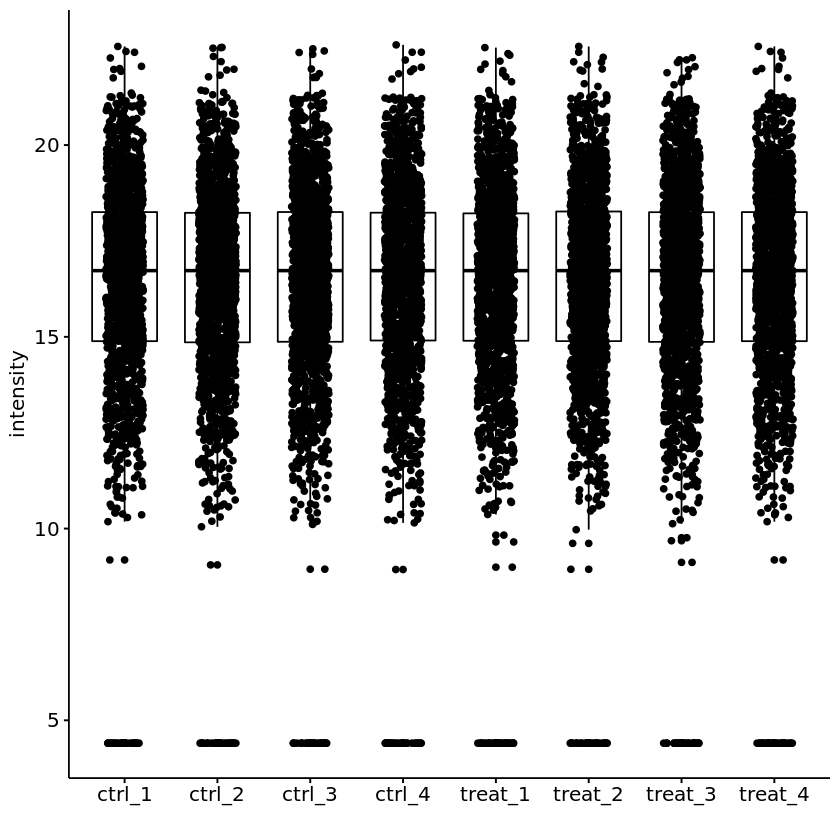

In [15]:
ggboxplot(gather(data.trans,colnames(data.trans)[2:ncol(data.trans)],key="sample",value="intensity"), 
          x = 
          "sample", y="intensity", xlab="",
         palette = get_palette(palette = "npg", 6),
         add = "jitter")

# (4) exploratory data analysis

## (4.1) Filtering

In [16]:
stddev <- apply(data.trans[,2:ncol(data.trans)],1,sd)
means <- rowMeans(data.trans[,2:ncol(data.trans)])
CV <- stddev/means

data <- data.trans[CV>0.2,]
head(CV)
nrow(data.trans)
nrow(data)

1           2           3           4           5           6 
0.048219245 0.604060866 0.008485487 0.058787001 0.075095388 0.645821870

[1] 1610

[1] 120

## (4.2) Principal component analysis (PCA)

PCA is commonly used as data exploratory tool in quality assessement to detect potential outlier samples or in feature selection. Introductory info about PCA can be found in the article by [Ringner;2008](http://www.marcottelab.org/users/BCH339N_2016/NBT_primer_PCA.pdf).

In [17]:
data.mat <- as.matrix(data[,2:ncol(data)])
rownames(data.mat) <- data$protein
head(data.mat)

,ctrl_1,ctrl_2,ctrl_3,ctrl_4,treat_1,treat_2,treat_3,treat_4
A0A024RBD0,4.403434,4.403434,4.403434,4.403434,15.49109,15.44652,15.37819,16.78580
A1L0T0,4.403434,4.403434,4.403434,4.403434,18.04294,18.36373,18.15713,16.27653
B7ZBA4,11.543687,11.550819,11.296042,11.602470,11.60031,11.15525,11.62925,19.30458
A3KMH1,4.403434,4.403434,4.403434,4.403434,15.88314,15.87877,16.00109,15.68559
A4D1E9,4.403434,4.403434,4.403434,4.403434,15.82627,15.94491,15.93403,13.54038
C9K0K2,4.403434,4.403434,4.403434,4.403434,15.80053,15.84968,15.81705,13.75406


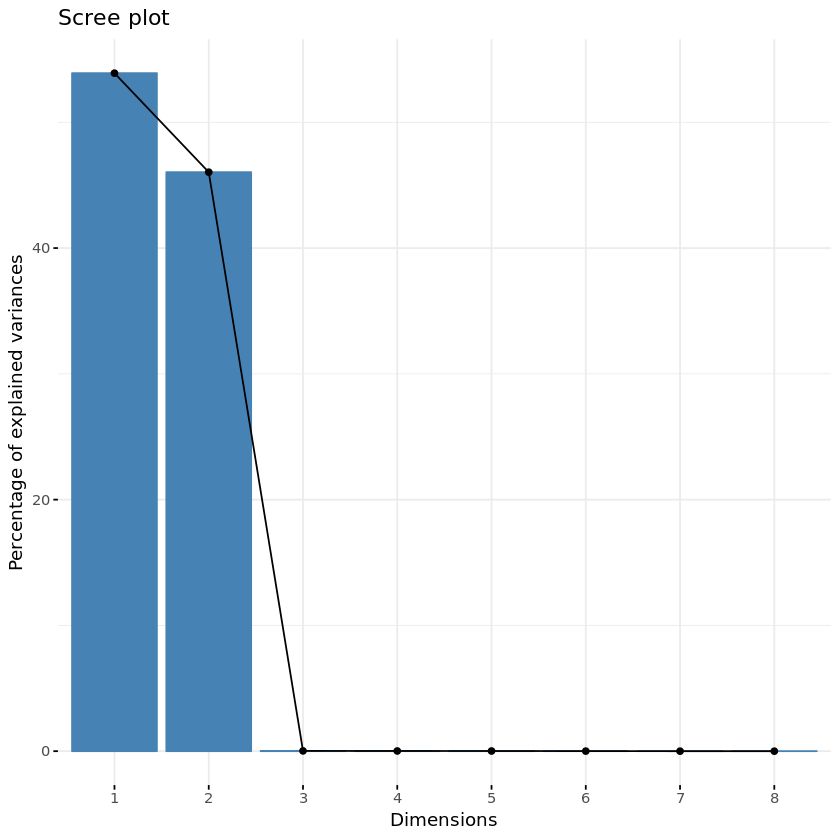

In [18]:
pca <- prcomp(t(data.mat),scale=TRUE)
fviz_eig(pca)

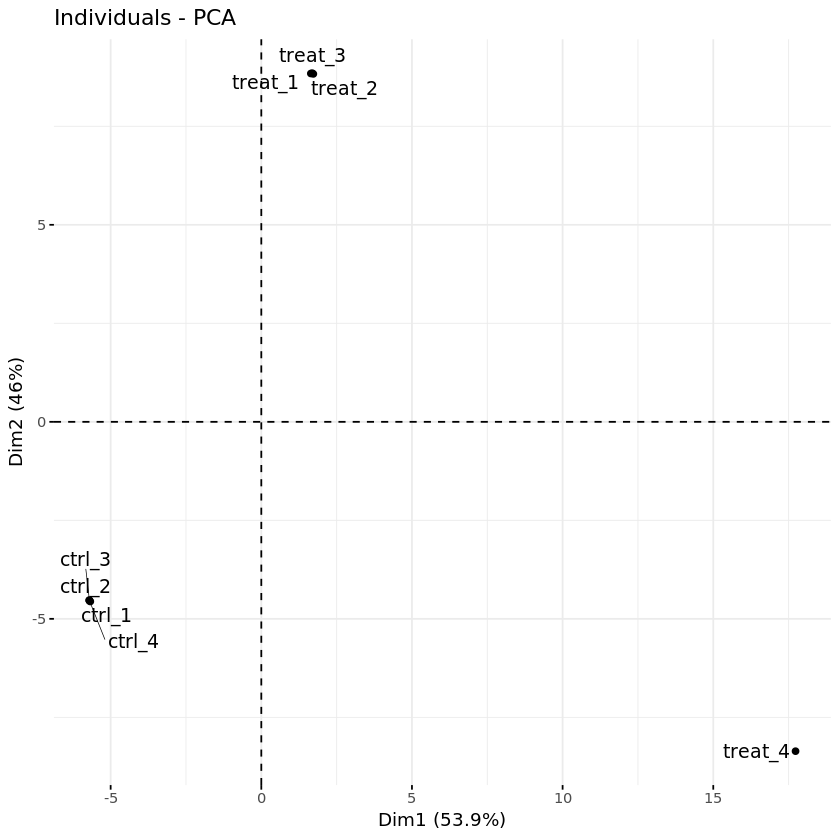

In [19]:
fviz_pca_ind(pca, repel = TRUE)

## (4.3) Agglomerative clustered heatmap

We perform an **unsupervised** learning approach by **hierarchical average clustering** the samples according to their **euclidean distances** in protein expression. For more detailed info about clustering see [Shannon *et.al*;2003](https://www.ncbi.nlm.nih.gov/pubmed/12517285)

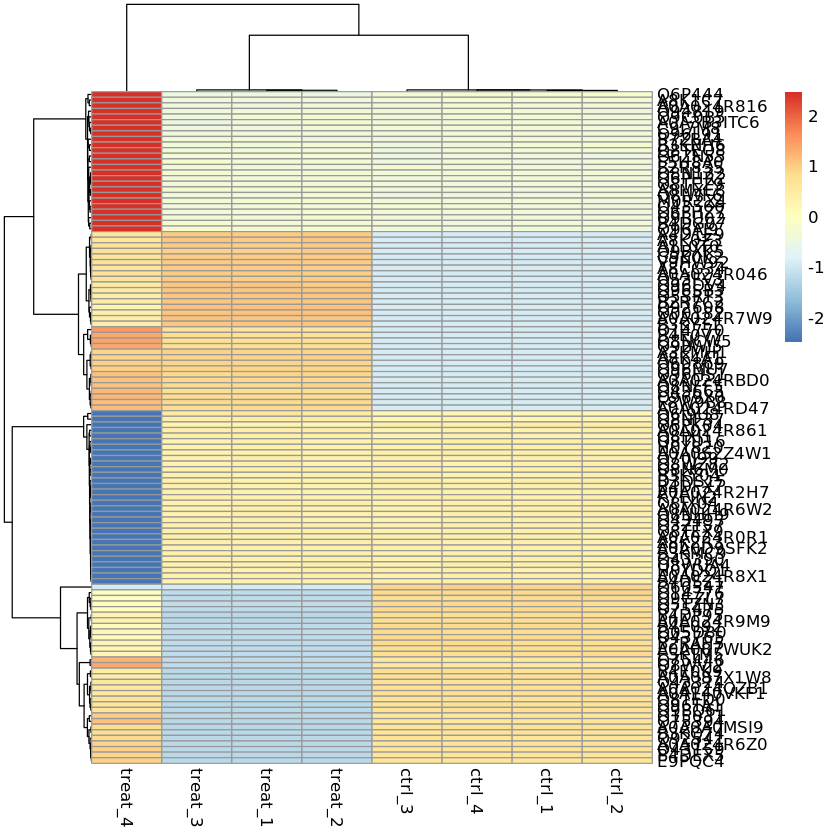

In [20]:
pheatmap(data.mat, scale="row",clustering_distance_cols = "euclidean", clustering_method = "average")

## (4.4) Differential expression analysis

In [21]:
head(data.trans)

protein,ctrl_1,ctrl_2,ctrl_3,ctrl_4,treat_1,treat_2,treat_3,treat_4
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C9J600,16.533415,16.438800,16.501493,16.689725,16.29620,16.30852,16.24324,14.26575
A0A024RBD0,4.403434,4.403434,4.403434,4.403434,15.49109,15.44652,15.37819,16.78580
A0A024RDB0,19.927581,19.882584,19.826382,19.950174,19.87400,19.76466,19.95774,20.32537
A0JNW5,13.519825,13.717404,13.370199,13.412868,13.50548,13.60246,13.38014,15.76893
A0MZ66,12.404289,12.403024,12.496576,12.496282,12.47491,12.49226,12.23287,15.12854
A1L0T0,4.403434,4.403434,4.403434,4.403434,18.04294,18.36373,18.15713,16.27653


In [22]:
n.treat <- 3
n.ctrl <- 4

data.mat <- as.matrix(data.trans[,2:(ncol(data.trans))])
data.mat <- data.mat[,c(-8)] # you can discard samples by -column index
rownames(data.mat) <- data.trans$protein

calc.pval <- function(int){(t.test(x=int[1:n.ctrl],y=int[(n.ctrl+1):(n.treat+n.ctrl)]))[["p.value"]]}
calc.FC <- function(int){mean(int[(n.ctrl+1):(n.treat+n.ctrl)])-mean(int[1:n.ctrl])}

data <- data.frame(protein=data.trans$protein,
                   logFC=apply(data.mat,1,calc.FC),
                   pval=apply(data.mat,1,calc.pval))
head(data)

,protein,logFC,pval
,<fct>,<dbl>,<dbl>
C9J600,C9J600,-0.258206145,1.197124e-02
A0A024RBD0,A0A024RBD0,11.035164154,8.852216e-06
A0A024RDB0,A0A024RDB0,-0.031215282,6.508467e-01
A0JNW5,A0JNW5,-0.009049487,9.318846e-01
A0MZ66,A0MZ66,-0.050026213,6.178362e-01
A1L0T0,A1L0T0,13.784500272,4.637779e-05


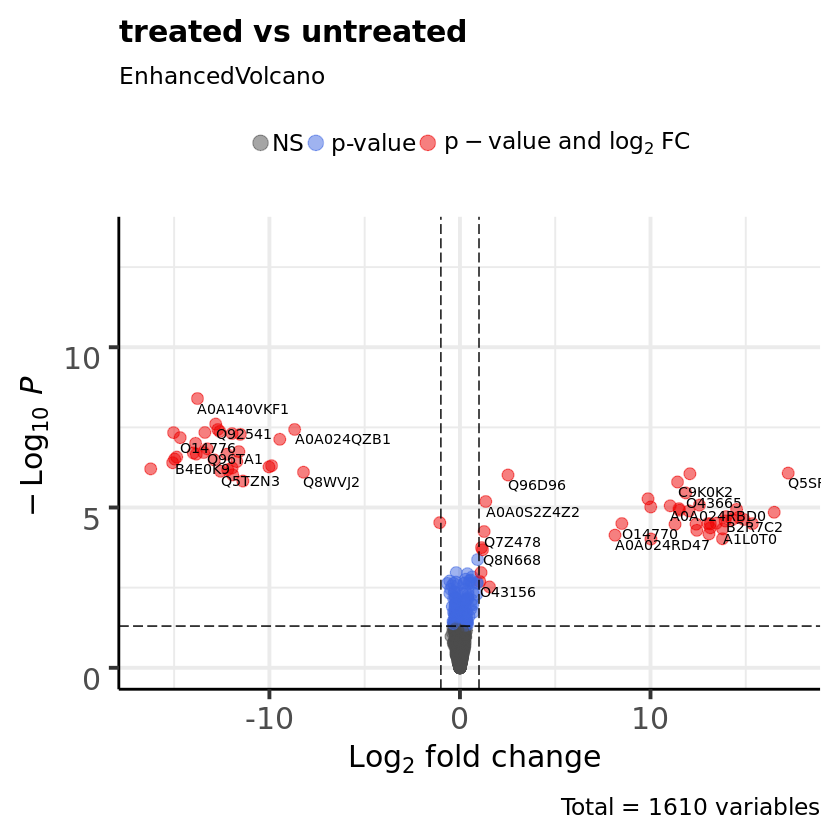

In [23]:
EnhancedVolcano(data,
    title = 'treated vs untreated',
    lab = data$protein,
    x = 'logFC',
    y = 'pval',
    pCutoff = 0.05,
    FCcutoff = 1.0,
    pointSize = 3.0,
    labSize = 3.0)

## (4.5) Multiple testing problem

As we are running many statistical tests on our dataset, we have to expect an inflation of false positives. Therefore we correct the p-values for multiple testing and determine the **false discovery rate** (FDR). More details see [Storey & Tibshirani; 2003](https://www.ncbi.nlm.nih.gov/pubmed/12883005)

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”

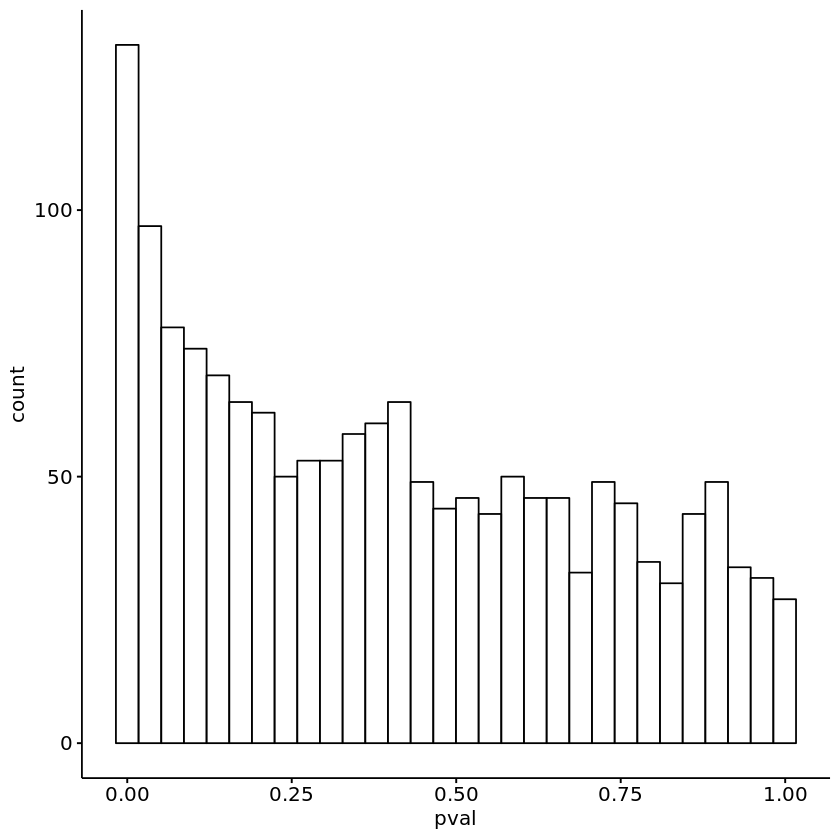

In [24]:
gghistogram(data, x = "pval")

In [25]:
data$FDR <- p.adjust(data$pval, method = "BH")
head(data)

,protein,logFC,pval,FDR
,<fct>,<dbl>,<dbl>,<dbl>
C9J600,C9J600,-0.258206145,1.197124e-02,0.1592867591
A0A024RBD0,A0A024RBD0,11.035164154,8.852216e-06,0.0003476114
A0A024RDB0,A0A024RDB0,-0.031215282,6.508467e-01,0.8630857397
A0JNW5,A0JNW5,-0.009049487,9.318846e-01,0.9767801012
A0MZ66,A0MZ66,-0.050026213,6.178362e-01,0.8532407935
A1L0T0,A1L0T0,13.784500272,4.637779e-05,0.0012043265


# (5) functional analysis

One basic approach in functional analysis of protein expression is **enrichment analysis**. Based on a **hypergeometric test** we can assess wether the occurrence of a dysregulated protein within a pre-specified **subset** (e.g. pathway) is greater than expected by chance. Details see [Picart-Armada *et.al.*;2017](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0189012)

## (5.1) selection of significantly dysregulated features 

In [26]:
features <- data %>% filter(abs(logFC)>log2(1.5),FDR<=0.10) %>% dplyr::select(protein)
nrow(features)
head(features)

write.csv(data, file = "FC_pval_table.csv", row.names = FALSE)
write.csv(features, file = "features.csv", row.names = FALSE)

[1] 81

protein
<fct>
A0A024RBD0
A1L0T0
A3KMH1
A4D1E9
C9K0K2
A8CG34


## (5.2) overrepresentation analysis of Reactome pathways

In [27]:
# Biological Id TranslatoR
feature.ids = bitr(features$protein, fromType="UNIPROT", toType="ENTREZID", OrgDb="org.Hs.eg.db")
head(feature.ids)



'select()' returned 1:1 mapping between keys and columns
Warning message in bitr(features$protein, fromType = "UNIPROT", toType = "ENTREZID", :
“24.69% of input gene IDs are fail to map...”

,UNIPROT,ENTREZID
,<chr>,<chr>
1,A0A024RBD0,11163
2,A1L0T0,10994
3,A3KMH1,23078
4,A4D1E9,85865
7,A8K0Z3,100287171
8,V9HW92,9124


In [28]:
enrich.res <- enrichPathway(gene=feature.ids$ENTREZID,pvalueCutoff=0.9, qvalueCutoff = 0.9,readable=T)
head(as.data.frame(enrich.res))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
R-HSA-69618,R-HSA-69618,Mitotic Spindle Checkpoint,3/36,112/10654,0.006274691,0.2819644,0.2577881,UBE2C/DYNC1LI2/KIF2C,3
R-HSA-72165,R-HSA-72165,mRNA Splicing - Minor Pathway,2/36,52/10654,0.013240336,0.2819644,0.2577881,DDX23/SF3B5,2
R-HSA-2151201,R-HSA-2151201,Transcriptional activation of mitochondrial biogenesis,2/36,56/10654,0.015248040,0.2819644,0.2577881,NCOR1/TFB1M,2
R-HSA-1834949,R-HSA-1834949,Cytosolic sensors of pathogen-associated DNA,2/36,63/10654,0.019054350,0.2819644,0.2577881,CGAS/MYD88,2
R-HSA-2467813,R-HSA-2467813,Separation of Sister Chromatids,3/36,190/10654,0.025898311,0.2819644,0.2577881,UBE2C/DYNC1LI2/KIF2C,3
R-HSA-8852135,R-HSA-8852135,Protein ubiquitination,2/36,79/10654,0.029066135,0.2819644,0.2577881,UBE2C/RTF1,2


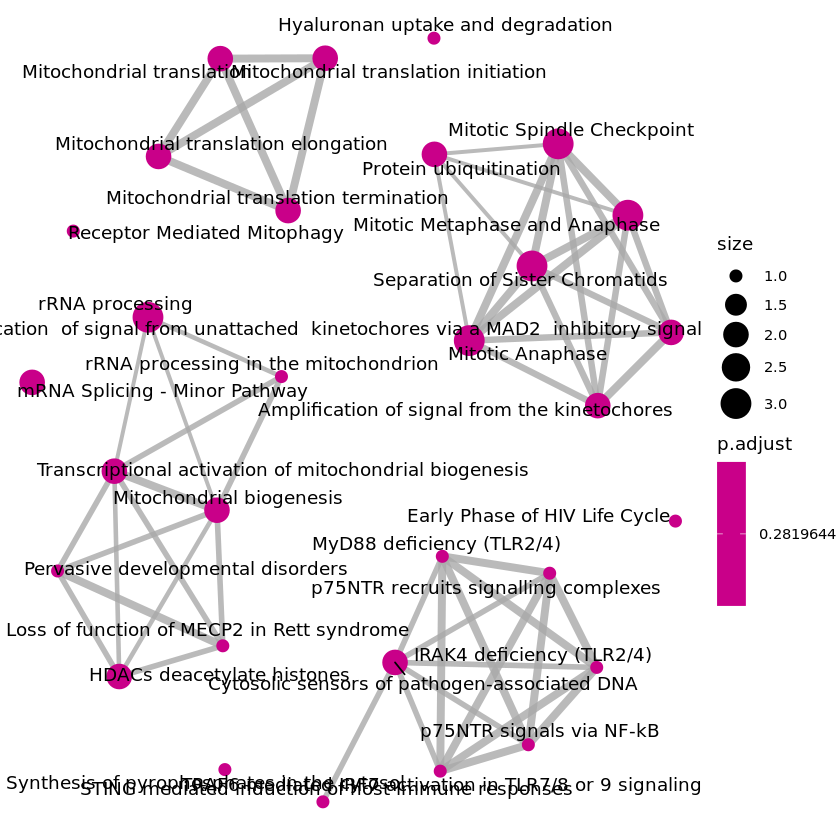

In [29]:
emapplot(enrich.res)

For more detailed analysis of enriched pathways you can load the respective info from the [**Reactome**](https://reactome.org/) online repository. The is plethora of **online tools** for functional analysis like [**DAVID**](https://david.ncifcrf.gov/) or the [**STRING**](https://string-db.org/) database. Another open enrichment and network analysis platform is offered by [**CYTOSCAPE**](https://cytoscape.org/).